# Capstone Week 3
Made with Gemini (on Colab) - especially comments, ChatGPT 5.1 and Claude.ai

**Just run all cells**
**Then look at the last cells for results**
(beginning with 'Configuration')

From README.md
# Capstone Week 3 - Transformer Models Summary
I have made the Capstone Week 3 with extensive help from Claude.ai and Gemini.
I have spent a lot of time working to understand the core concepts - as the attention mechanism, masks, positional encoding, etc. The main part of my time was spent on understanding the mechanisms - not on code generation.

But I could not help challenging Claude.ai to make an implementation for volatility prediction (from SPY):
The point would be to reuse as many parts from Capstone Week 3 as possible. I used data from my Alpaca.markets subscription when running locally (using my keys) or publicly on a csv file hosted on GitHub.

## Conclusion:
Even using Claude.ai and Gemini I think it was very useful to tweak the parameters and devices: not so surprising very slow with CPU, faster with T4 GPU. Most of the loss progress was done after 2000 steps. With the Capstone Week 3 file I worked with 4 and 8 attention heads - and even for num_heads=1. Differences were noticeable but not dramatic.  

The transformer for volatility prediction (with num_heads=4) achieved RMSE of  7.673% vs EWMA's 3.596%. In the Mincer-Zarnowitz regression R² was 0.0003 vs 0.5158 for EWMA. That's hardly surprising. The transformer underperformed EWMA baselines, which highlights that architectural sophistication doesn't guarantee success on noisy (very few) financial data. With only ~1,245 days of SPY data and 128 test sequences, the model was not able to learn much. The most valuable insight was understanding how multi-head attention transformer models can learn content-based dependencies between inputs.

I have created two notebooks:

## 1. CapstoneWeek3 Notebook: Character-Level Language Model

This notebook implements a decoder-only transformer for character-level language modeling.
The model uses scaled dot-product attention, multi-head attention, and transformer blocks with Pre-LN structure.
Training uses cross-entropy loss to predict the next character from a small text corpus.
Key components include: `scaled_dot_product_attention`, `MultiHeadAttention`, `TransformerBlock`, and `PositionalEncoding`.
The model generates text samples using temperature-controlled sampling after training on approx. 35,000 characters.

## 2. Vol_transformer_public Notebook: Volatility Forecasting Model

This notebook adapts the same transformer architecture for predicting 5-day forward realized volatility of SPY.
Input features include log returns, absolute returns, high-low range, volume changes, and historical volatility.
The model outputs a single regression value (MSE loss) instead of vocabulary probabilities.
Evaluation uses Mincer-Zarnowitz regression and compares against naive and EWMA baseline forecasts.
Data comes from Alpaca.markets API (or GitHub CSV fallback) with proper chronological train/val/test splits.

## 3. Comments on Using Transformers for Volatility Prediction

The attention mechanism enables in principle the model to identify which past days are most relevant for current volatility.
Unlike EWMA which use fixed decay weights, transformers can learn dynamic, content-based dependencies.
Volatility clustering and regime changes could benefit from the model's ability to attend to distant past events.
The architecture generalizes well because attention doesn't distinguish between text tokens and numerical features.
However, financial data is noisier and less structured than language, making patterns harder to learn reliably. As mentioned above, the model was not able to learn much with only ~1,245 days of SPY data and 128 test sequences.

## 4. Key Differences Between the Two Models

| Aspect | Language Model | Volatility Model |
|--------|----------------|------------------|
| **Input Layer** | `nn.Embedding(vocab_size, d_model)` - discrete tokens | `nn.Linear(num_features, d_model)` - continuous features |
| **Output Layer** | `nn.Linear(d_model, vocab_size)` - softmax over vocabulary | `nn.Linear(d_model, 1)` - single regression value |
| **Loss Function** | Cross-entropy (classification) | Mean Squared Error (regression) |
| **Evaluation** | Loss, bits-per-character, qualitative samples | RMSE, MAE, Mincer-Zarnowitz R² |
| **Data Split** | Random or sequential (order matters less for training) | Strictly chronological (no future data leakage) |

In [ ]:
import torch
import torch.nn.functional as F

## A. Scaled dot-product attention (single head)

In [ ]:


def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Computes the scaled dot product attention.
    Q, K, V: (..., T, d_k / d_v) tensors
    mask:    optional boolean or float mask broadcastable to (..., T, T)
    returns: (..., T, d_v)

    Meaning:
    The tensors can have any number of dimensions before the last two.
    For example, Q could be (T, d_k) (2 dimensions),
    or (Batch_size, T, d_k) (3 dimensions),
    or even (Batch_size, Head_count, T, d_k) (4 dimensions), and so on.
    """

    # 1. Compute scaled scores
    d_k = Q.shape[-1] # Get the dimension of the key vectors
    # Compute dot products of Q and K, then scale by sqrt(d_k)
    scores_unscaled = Q @ K.transpose(-2, -1)
    scores = scores_unscaled / torch.sqrt(torch.tensor(d_k, dtype=Q.dtype))

    # 2. Add mask (if given)
    if mask is not None:
        # mask: True for positions to block or large negative for float masks
        if mask.dtype == torch.bool:
            # Set masked positions to a very small number (-inf) to be ignored by softmax
            scores = scores.masked_fill(mask, float('-inf'))
        else:  # float mask (e.g., -1e9)
            scores = scores + mask # Add a float mask to the scores

    # 3. Apply softmax along the last-but-one dimension
    attn = F.softmax(scores, dim=-1) # Apply softmax to get attention weights

    # 4. Multiply by V to get the output
    output = attn @ V # Multiply attention weights by V to get the weighted sum of values

    return scores_unscaled, scores, attn, output

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(attn, Q, K, title='Attention Weights Heatmap', cmap='Blues', figsize=(6, 5)):
    """
    Visualizes attention weights as a heatmap. Handles batched attention tensors.

    Args:
        attn (torch.Tensor): The attention weights tensor. Can be (..., T, T) or (T, T).
        Q (torch.Tensor): The Query tensor (used for y-axis labels). Can be (..., T, d_k) or (T, d_k).
        K (torch.Tensor): The Key tensor (used for x-axis labels). Can be (..., T, d_k) or (T, d_k).
        title (str): The title of the heatmap.
        cmap (str): The colormap to use (e.g., 'Blues', 'viridis').
        figsize (tuple): The figure size (width, height).
    """
    plot_data = attn.detach().numpy()

    if plot_data.ndim == 2:  # Single attention matrix (T, T)
        plt.figure(figsize=figsize)
        sns.heatmap(plot_data, annot=True, cmap=cmap, fmt=".2f",
                    xticklabels=[f'Key {i+1}' for i in range(K.shape[-2])],
                    yticklabels=[f'Query {i+1}' for i in range(Q.shape[-2])])
        plt.title(title)
        plt.xlabel('Keys')
        plt.ylabel('Queries')
        plt.show()
    elif plot_data.ndim == 3:  # Batched attention matrices (B, T, T)
        batch_size = plot_data.shape[0]
        for i in range(batch_size):
            plt.figure(figsize=figsize)

            # Adjust Q and K for labels if they are also batched, otherwise use the original 2D Q/K
            Q_labels_source = Q[i] if Q.ndim == 3 else Q
            K_labels_source = K[i] if K.ndim == 3 else K

            sns.heatmap(plot_data[i], annot=True, cmap=cmap, fmt=".2f",
                        xticklabels=[f'Key {j+1}' for j in range(K_labels_source.shape[-2])],
                        yticklabels=[f'Query {j+1}' for j in range(Q_labels_source.shape[-2])])
            plt.title(f"{title} (Batch Item {i+1})")
            plt.xlabel('Keys')
            plt.ylabel('Queries')
            plt.show()
    else:
        print(f"Warning: Cannot plot attention heatmap for tensor with {plot_data.ndim} dimensions. Expected 2 or 3.")

In [ ]:
from __future__ import annotations
# This import is needed to make Python treat type hints
# so they are treated as strings instead of real Python objects at function-definition time.

def causal_mask(batch: int, time: int, device: torch.device | None = None) -> Tensor:
    # Create a lower triangular matrix of ones. Positions above the diagonal will be False (0).
    # We then invert this to get True for positions to be masked (above the diagonal).
    base = torch.tril(torch.ones(time, time, dtype=torch.bool, device=device))
    # Invert the mask: True for positions to mask (upper triangle), False for positions to keep.
    mask = ~base
    return mask.unsqueeze(0).expand(batch, -1, -1)            # [B, T, T] (boolean mask)

## Numerical example

In [ ]:
# Numerical example
Q = torch.tensor([[1, 0],
                  [0, 1],
                  [1, 1]], dtype=torch.float32)

K = torch.tensor([[1, 0],
                  [1, 1],
                  [0, 1]], dtype=torch.float32)

V = torch.tensor([[1, 0],
                  [0, 2],
                  [3, 1]], dtype=torch.float32)


### Without causal mask

In [ ]:
scaled_dot_product_attention(Q, K, V)

(tensor([[1., 1., 0.],
         [0., 1., 1.],
         [1., 2., 1.]]),
 tensor([[0.7071, 0.7071, 0.0000],
         [0.0000, 0.7071, 0.7071],
         [0.7071, 1.4142, 0.7071]]),
 tensor([[0.4011, 0.4011, 0.1978],
         [0.1978, 0.4011, 0.4011],
         [0.2483, 0.5035, 0.2483]]),
 tensor([[0.9944, 1.0000],
         [1.4011, 1.2033],
         [0.9930, 1.2552]]))

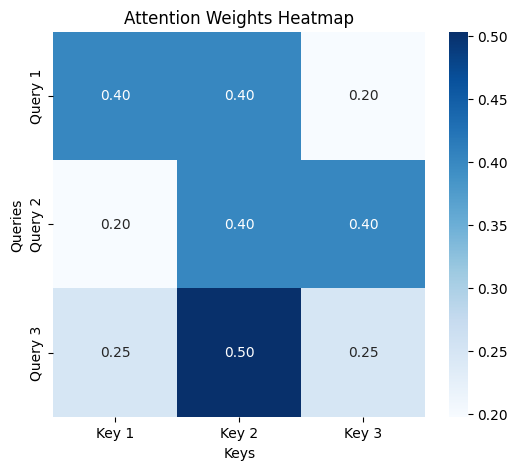

In [ ]:
# Call the scaled_dot_product_attention function to get weights
scores_unscaled, scores, attn, output = scaled_dot_product_attention(Q, K, V)

# Call the new function to plot the heatmap
plot_attention_heatmap(attn, Q, K, cmap='Blues')

### With causal mask

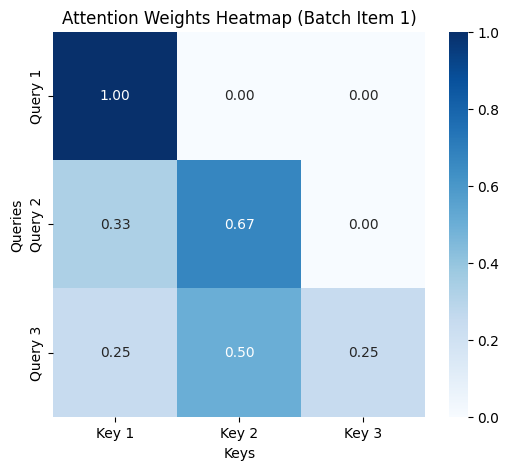

In [ ]:
mask = causal_mask(1, 3, torch.device('cpu'))

# Call the scaled_dot_product_attention function to get weights
scores_unscaled, scores, attn, output = scaled_dot_product_attention(Q, K, V, mask)

# Call the new function to plot the heatmap
plot_attention_heatmap(attn, Q, K)

### Conclusion
With the causal mask we see the attention weights equal to 0 over the diagonal as expected

## B. Self-Attention for Sequences

In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k=None, d_v=None, causal=True):
        super().__init__()
        d_k = d_k or d_model
        d_v = d_v or d_model
        self.W_Q = nn.Linear(d_model, d_k, bias=False)
        self.W_K = nn.Linear(d_model, d_k, bias=False)
        self.W_V = nn.Linear(d_model, d_v, bias=False)
        self.causal = causal

    def forward(self, x):
        # x: (B, T, d_model)
        B, T, d_model = x.shape # Extract batch size and sequence length
        Q = self.W_Q(x)    # (B, T, d_k)
        K = self.W_K(x)    # (B, T, d_k)
        V = self.W_V(x)    # (B, T, d_v)
        # Pass batch size (B) and sequence length (T) to causal_mask
        mask = causal_mask(B, T, device=x.device) if self.causal else None # causal mask defined in section A
        scores_unscaled, scores, attn, output = scaled_dot_product_attention(Q, K, V, mask=mask) # also defined in section A
        return scores_unscaled, scores, attn, output # (B, T, d_v)

test

In [ ]:
# Set a random seed for reproducibility
torch.manual_seed(100)

# Set all projections to identity
d = 4
attn = SelfAttention(d_model=d, causal=True)

with torch.no_grad():
    attn.W_Q.weight.copy_(torch.eye(d))
    attn.W_K.weight.copy_(torch.eye(d))
    attn.W_V.weight.copy_(torch.eye(d))

# Test input
X = torch.randn(1, 3, d)  # batch=1, T=3

# Get output
_, _, attn_weights, output = attn(X)

# Check: attention weights should be nearly uniform
print("Attention weights:\n", attn_weights)

# Check: output should be close to mean of X across positions
expected = X.mean(dim=1, keepdim=True).expand_as(X)
print("Output \u2248 row-wise mean?", torch.allclose(output, expected, atol=1e-5))


Attention weights:
 tensor([[[1.0000, 0.0000, 0.0000],
         [0.2875, 0.7125, 0.0000],
         [0.6448, 0.0905, 0.2647]]], grad_fn=<SoftmaxBackward0>)
Output ≈ row-wise mean? False


As far as I can see I can not test with W_q, W_k and W_v = I. So that the output is not the mean is expected

## C. Multi-Head Attention

In [ ]:
from __future__ import annotations
# This import is needed to make Python treat type hints
# so they are treated as strings instead of real Python objects at function-definition time.

def make_causal_mask_from_T(T: int, device: torch.device | None = None) -> Tensor:
    """Creates a causal mask of shape (1, 1, T, T) for multi-head attention."""
    base = torch.tril(torch.ones(T, T, dtype=torch.bool, device=device))
    mask = ~base  # True for positions to block
    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, T, T)

In [ ]:
# Adjusted a bit to make return only output (as a possiblity)
def scaled_dot_product_attention_rev(Q, K, V, mask=None, return_intermediates=False):
    """
    Computes the scaled dot product attention.
    Q, K, V: (..., T, d_k / d_v) tensors
    mask:    optional boolean or float mask broadcastable to (..., T, T)
    return_intermediates: if True, return (scores_unscaled, scores, attn, output)
                          if False, return just output
    returns: (..., T, d_v) or tuple (needed in the  MultiHeadAttention class)
    """

    # 1. Compute scaled scores
    d_k = Q.shape[-1]
    scores_unscaled = Q @ K.transpose(-2, -1)
    scores = scores_unscaled / torch.sqrt(torch.tensor(d_k, dtype=Q.dtype))

    # 2. Add mask (if given)
    if mask is not None:
        if mask.dtype == torch.bool:
            scores = scores.masked_fill(mask, float('-inf'))
        else:
            scores = scores + mask

    # 3. Apply softmax along the last-but-one dimension
    attn = F.softmax(scores, dim=-1)

    # 4. Multiply by V to get the output
    output = attn @ V

    if return_intermediates:
        return scores_unscaled, scores, attn, output
    return output

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0, causal=True):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.causal = causal

        # Linear layers to project input into Query, Key, and Value matrices
        self.proj_qkv = nn.Linear(d_model, 3 * d_model, bias=False) # Projects input to Q, K, V concatenated
        # Final linear layer to combine outputs from all attention heads
        self.proj_out = nn.Linear(d_model, d_model, bias=False)   # Final linear layer after concatenating heads
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, D = x.shape  # D = d_model: Batch size, Sequence length, Model dimension

        # 1. Project input `x` to obtain Q, K, V for all heads combined
        qkv = self.proj_qkv(x)                              # (B, T, 3*D) - Project input x to Q, K, V

        # 2. Reshape Q, K, V to separate them and allocate for each head
        qkv = qkv.view(B, T, 3, self.num_heads, self.d_head) # Reshape to separate Q, K, V and heads
        # Split the combined QKV tensor into individual Q, K, V tensors
        Q, K, V = qkv.unbind(dim=2)                         # each: (B, T, H, d_head) - Split into individual Q, K, V tensors

        # 3. Transpose Q, K, V to move the `num_heads` dimension before the `sequence_length` dimension
        # This makes it ready for batched matrix multiplication across heads
        Q = Q.transpose(1, 2)                               # (B, H, T, d_head) - Transpose to put heads dimension first
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # 4. Create and apply causal mask if enabled, to prevent attending to future tokens
        # FIX: Pass x.device to ensure the mask is created on the same device as the input tensor.
        mask = make_causal_mask_from_T(T, device=x.device) if self.causal else None # (1, 1, T, T) mask

        # 5. Apply scaled dot product attention for each head
        # The `scaled_dot_product_attention_rev` function handles the core attention logic
        Y = scaled_dot_product_attention_rev(Q, K, V, mask=mask)  # (B, H, T, d_head)

        # 6. Concatenate outputs from all attention heads
        # First, transpose back to (B, T, H, d_head), then contiguous().view() combines heads
        Y = Y.transpose(1, 2).contiguous().view(B, T, D)    # (B, T, D) - Transpose back and concatenate all head outputs

        # 7. Apply a final linear projection and dropout to the combined output
        Y = self.proj_out(Y)                                # (B, T, D) - Apply final linear projection
        Y = self.dropout(Y)                                 # Apply dropout
        return Y

Simple test:  It initializes the module, creates a random input tensor, and then passes it through the attention mechanism, printing the shape of the output.

In [ ]:
import torch.nn as nn

# Test the MultiHeadAttention class
d_model = 64  # Embedding dimension
num_heads = 8 # Number of attention heads
batch_size = 2
sequence_length = 10

# Instantiate the MultiHeadAttention module
mha_layer = MultiHeadAttention(d_model=d_model, num_heads=num_heads, causal=True)

# Create a dummy input tensor (batch_size, sequence_length, d_model)
# Represents a batch of sequences, where each token has d_model features
x_input = torch.randn(batch_size, sequence_length, d_model)

# Pass the input through the MultiHeadAttention layer
output = mha_layer(x_input)

print(f"Input shape: {x_input.shape}")
print(f"Output shape: {output.shape}")
#print(x_input)

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.0, causal=True):
        super().__init__()

        # Multi-head attention (from Section 6.3)
        self.attention = MultiHeadAttention(d_model, num_heads, dropout, causal)

        # Feedforward network (from Section 6.4)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
        )

        # Layer norms (Section 6.5)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention sublayer with residual connection (Pre-LN style)
        x = x + self.attention(self.ln1(x))

        # FFN sublayer with residual connection
        x = x + self.dropout(self.ffn(self.ln2(x)))

        return x


In [ ]:
# Test the TransformerBlock class
d_model = 64  # Embedding dimension
num_heads = 8 # Number of attention heads
d_ff = 256    # Feedforward network dimension
batch_size = 2
sequence_length = 10

# Instantiate the TransformerBlock module
transformer_block = TransformerBlock(d_model=d_model, num_heads=num_heads, d_ff=d_ff, causal=True)

# Create a dummy input tensor (batch_size, sequence_length, d_model)
x_input_block = torch.randn(batch_size, sequence_length, d_model)

# Pass the input through the TransformerBlock
output_block = transformer_block(x_input_block)

print(f"Input shape to TransformerBlock: {x_input_block.shape}")
print(f"Output shape from TransformerBlock: {output_block.shape}")

Input shape to TransformerBlock: torch.Size([2, 10, 64])
Output shape from TransformerBlock: torch.Size([2, 10, 64])


From section 7.3 in the handout

In [ ]:
import math # Import math module for log function

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        # Create a tensor for positional encodings, initialized to zeros
        pe = torch.zeros(max_len, d_model)   # (T_max, d_model) where T_max is max_len, d_model is embedding dimension

        # Generate positions (0, 1, ..., max_len-1) and unsqueeze to make it (max_len, 1)
        position = torch.arange(0, max_len).unsqueeze(1)

        # Calculate the 'division term' for the sinusoidal functions
        # This ensures that different dimensions (d_model) have different wavelengths
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # Apply sine to even indices in d_model dimension
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in d_model dimension
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension at the beginning (1, T_max, d_model)
        pe = pe.unsqueeze(0)                            # (1, T_max, d_model)

        # Register 'pe' as a buffer, so it's part of the module's state
        # but not considered a trainable parameter (e.g., it moves with the model to GPU)
        self.register_buffer('pe', pe)                  # not a parameter

    def forward(self, x):
        # x: (B, T, d_model) - Input tensor with batch, sequence length, and model dimension
        T = x.size(1) # Get the current sequence length of the input batch

        # Add the positional encodings to the input embeddings
        # self.pe[:, :T, :] slices the pre-computed positional encoding to match
        # the current sequence length T of the input 'x'.
        return x + self.pe[:, :T, :]

In [ ]:
class TinyTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super().__init__()
        # 1. Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        # 2. Positional encoding (your existing class!)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        # 3. Stack of transformer blocks (your existing class!)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout, causal=True)
            for _ in range(num_layers)
        ])

        # 4. Final layer norm and output projection
        self.ln_final = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # x: (B, T) integer token IDs
        x = self.token_embedding(x)      # (B, T, d_model)
        x = self.pos_encoding(x)         # (B, T, d_model) with position info

        for block in self.blocks:
            x = block(x)                 # (B, T, d_model)

        x = self.ln_final(x)             # (B, T, d_model)
        logits = self.lm_head(x)         # (B, T, vocab_size)
        return logits

Section 8.4. in the hand-out

In [ ]:
# =============================================================================
# DATA UTILITIES
# =============================================================================
# The Nicomachean Ethics of Aristotle 1309 (spaces included)
"""text2 =
'Every art, and every science reduced to a teachable form, and in like
manner every action and moral choice, aims, it is thought, at some
good: for which reason a common and by no means a bad description of
the Chief Good is, “that which all things aim at.”

Now there plainly is a difference in the Ends proposed: for in some
cases they are acts of working, and in others certain works or tangible
results beyond and beside the acts of working: and where there are
certain Ends beyond and beside the actions, the works are in their
nature better than the acts of working. Again, since actions and arts
and sciences are many, the Ends likewise come to be many: of the
healing art, for instance, health; of the ship-building art, a vessel;
of the military art, victory; and of domestic management, wealth; are
respectively the Ends.

And whatever of such actions, arts, or sciences range under some one
faculty (as under that of horsemanship the art of making bridles, and
all that are connected with the manufacture of horse-furniture in
general; this itself again, and every action connected with war, under
the military art; and in the same way others under others), in all
such, the Ends of the master-arts are more choice-worthy than those
ranging under them, because it is with a view to the former that the
latter are pursued.'"""

def load_text(source='default'):
    """
    Load or define the training corpus.
    For the capstone, we use a small text that fits in memory.
    """
    if source == 'default':
        # A small corpus of famous quotes (you can replace with anything!)
        text = """
        The only way to do great work is to love what you do.
        Innovation distinguishes between a leader and a follower.
        Stay hungry, stay foolish.
        The future belongs to those who believe in the beauty of their dreams.
        It is during our darkest moments that we must focus to see the light.
        The best time to plant a tree was twenty years ago. The second best time is now.
        Your time is limited, do not waste it living someone else's life.
        The only impossible journey is the one you never begin.
        Success is not final, failure is not fatal: it is the courage to continue that counts.
        Believe you can and you are halfway there.
        """
        # Repeat to make it larger (helps with training)
        text = text * 50  # ~25,000 characters
    else:
        # Load from file or URL
        text = source

    print(f"Corpus size: {len(text)} characters")
    return text


class CharTokenizer:
    """
    Simple character-level tokenizer.
    Maps each unique character to an integer ID and back.
    """
    def __init__(self, text):
        # Get sorted list of unique characters
        self.chars = sorted(set(text))
        self.vocab_size = len(self.chars)

        # Create bidirectional mappings
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        print(f"Vocabulary size: {self.vocab_size} unique characters")
        print(f"Characters: {''.join(self.chars[:50])}{'...' if len(self.chars) > 50 else ''}")

    def encode(self, text):
        """Convert string to list of integers."""
        return [self.char_to_idx[ch] for ch in text]

    def decode(self, indices):
        """Convert list of integers back to string."""
        return ''.join([self.idx_to_char[i] for i in indices])


def prepare_data(text, tokenizer, train_split=0.9):
    """
    Encode text and split into training and validation sets.
    """
    # Encode entire text as tensor of integers
    data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

    # Split into train and validation
    split_idx = int(len(data) * train_split)
    train_data = data[:split_idx]
    val_data = data[split_idx:]

    print(f"Training set: {len(train_data)} tokens")
    print(f"Validation set: {len(val_data)} tokens")

    return train_data, val_data


def get_batch(data, block_size, batch_size, device):
    """
    Sample a random batch of training examples.

    Returns:
        x: Input sequences,  shape (B, T)
        y: Target sequences, shape (B, T)

    The target is simply the input shifted by one position.
    """
    # Maximum starting index (leave room for block_size + 1 tokens)
    max_start = len(data) - block_size - 1

    # Random starting positions for each sequence in the batch
    starts = torch.randint(0, max_start, (batch_size,))

    # Extract sequences
    x = torch.stack([data[i : i + block_size] for i in starts])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in starts])

    # Move to device (GPU if available)
    return x.to(device), y.to(device)
"""

**Let's trace through `get_batch` with a concrete example:**
```
data = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 9, 3]  (16 tokens)
block_size = 4
batch_size = 2

max_start = 16 - 4 - 1 = 11

Suppose random starts = [2, 8]

Batch item 0 (start=2):
    x[0] = data[2:6]   = [4, 1, 5, 9]
    y[0] = data[3:7]   = [1, 5, 9, 2]

    Position 0: input=4, target=1 (given '4', predict '1')
    Position 1: input=1, target=5 (given '4,1', predict '5')
    Position 2: input=5, target=9 (given '4,1,5', predict '9')
    Position 3: input=9, target=2 (given '4,1,5,9', predict '2')

Batch item 1 (start=8):
    x[1] = data[8:12]  = [5, 3, 5, 8]
    y[1] = data[9:13]  = [3, 5, 8, 9]

Final shapes:
    x: (2, 4)
    y: (2, 4)"""

"\n\n**Let's trace through `get_batch` with a concrete example:**\n```\ndata = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 9, 3]  (16 tokens)\nblock_size = 4\nbatch_size = 2\n\nmax_start = 16 - 4 - 1 = 11\n\nSuppose random starts = [2, 8]\n\nBatch item 0 (start=2):\n    x[0] = data[2:6]   = [4, 1, 5, 9]\n    y[0] = data[3:7]   = [1, 5, 9, 2]\n\n    Position 0: input=4, target=1 (given '4', predict '1')\n    Position 1: input=1, target=5 (given '4,1', predict '5')\n    Position 2: input=5, target=9 (given '4,1,5', predict '9')\n    Position 3: input=9, target=2 (given '4,1,5,9', predict '2')\n\nBatch item 1 (start=8):\n    x[1] = data[8:12]  = [5, 3, 5, 8]\n    y[1] = data[9:13]  = [3, 5, 8, 9]\n\nFinal shapes:\n    x: (2, 4)\n    y: (2, 4)"

In [ ]:
# =============================================================================
# CAUSAL MASK HELPER
# =============================================================================

def make_causal_mask_from_T(T, device=None):
    """
    Create a causal (look-ahead) mask for self-attention.

    Returns a boolean tensor of shape (1, 1, T, T) where:
        - True  = position should be MASKED (cannot attend)
        - False = position is allowed to attend

    The mask is upper triangular (True above diagonal).
    """
    # Create a matrix where mask[i,j] = True if j > i
    mask = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
    # Add batch and head dimensions for broadcasting: (1, 1, T, T)
    return mask.unsqueeze(0).unsqueeze(0)




In [ ]:
# =============================================================================
# TINY TRANSFORMER LANGUAGE MODEL
# =============================================================================

class TinyTransformerLM(nn.Module):
    """
    A small decoder-only transformer for character-level language modeling.

    Architecture:
        Token IDs → Embedding → Positional Encoding →
        [TransformerBlock × num_layers] → LayerNorm → Linear → Logits
    """

    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff,
                 max_len, dropout=0.1):
        super().__init__()

        self.d_model = d_model

        # 1. Token embedding: converts integer IDs to vectors
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        # 2. Positional encoding: adds position information
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        # 3. Dropout after embeddings
        self.dropout = nn.Dropout(dropout)

        # 4. Stack of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout, causal=True)
            for _ in range(num_layers)
        ])

        # 5. Final layer normalization
        self.ln_final = nn.LayerNorm(d_model)

        # 6. Output projection: maps hidden states to vocabulary logits
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # Optional: tie input and output embeddings (weight sharing)
        # This is common practice and reduces parameters
        # self.lm_head.weight = self.token_embedding.weight

        # Initialize weights
        self._init_weights()

        # Count parameters
        n_params = sum(p.numel() for p in self.parameters())
        print(f"Model initialized with {n_params:,} parameters")

    def _init_weights(self):
        """Initialize weights with small random values."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x):
        """
        Forward pass.

        Args:
            x: Token indices, shape (B, T)

        Returns:
            logits: Unnormalized scores for each vocabulary token, shape (B, T, V)
        """
        B, T = x.shape

        # Token embeddings: (B, T) → (B, T, d_model)
        tok_emb = self.token_embedding(x)

        # Add positional encodings: (B, T, d_model)
        x = self.pos_encoding(tok_emb)

        # Apply dropout
        x = self.dropout(x)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)  # (B, T, d_model)

        # Final layer norm
        x = self.ln_final(x)  # (B, T, d_model)

        # Project to vocabulary size
        logits = self.lm_head(x)  # (B, T, vocab_size)

        return logits

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens autoregressively.

        Args:
            idx: Starting context, shape (B, T) or (1, T)
            max_new_tokens: How many tokens to generate
            temperature: Controls randomness (lower = more deterministic)
            top_k: If set, only sample from top k most likely tokens

        Returns:
            Extended sequence with generated tokens, shape (B, T + max_new_tokens)
        """
        for _ in range(max_new_tokens):
            # Crop context if it exceeds max_len
            idx_cond = idx if idx.size(1) <= self.pos_encoding.pe.size(1) else idx[:, -self.pos_encoding.pe.size(1):]

            # Forward pass to get logits
            logits = self(idx_cond)  # (B, T, V)

            # Focus on the last position's predictions
            logits = logits[:, -1, :]  # (B, V)

            # Apply temperature
            logits = logits / temperature

            # Optional: top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            # Convert to probabilities
            probs = F.softmax(logits, dim=-1)  # (B, V)

            # Sample next token
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Append to sequence
            idx = torch.cat([idx, idx_next], dim=1)  # (B, T+1)

        return idx

"""
from claude.ai
**Understanding the `generate` method:**

This is how the model produces new text after training. The process is autoregressive:
```
Start with prompt: "The"
                    ↓
Forward pass → get probabilities for position after "The"
                    ↓
Sample from probabilities → get " " (space)
                    ↓
New context: "The "
                    ↓
Forward pass → get probabilities for position after "The "
                    ↓
Sample → get "o"
                    ↓
New context: "The o"
                    ↓
... continue for max_new_tokens iterations
                    ↓
Final output: "The only way to do great work..."""

'\nfrom claude.ai\n**Understanding the `generate` method:**\n\nThis is how the model produces new text after training. The process is autoregressive:\n```\nStart with prompt: "The"\n                    ↓\nForward pass → get probabilities for position after "The"\n                    ↓\nSample from probabilities → get " " (space)\n                    ↓\nNew context: "The "\n                    ↓\nForward pass → get probabilities for position after "The "\n                    ↓\nSample → get "o"\n                    ↓\nNew context: "The o"\n                    ↓\n... continue for max_new_tokens iterations\n                    ↓\nFinal output: "The only way to do great work...'

In [ ]:
# =============================================================================
# TRAINING LOOP
# =============================================================================

@torch.no_grad()
def estimate_loss(model, train_data, val_data, config, device):
    """
    Estimate average loss on train and validation sets.
    Uses multiple batches for a stable estimate.
    """
    model.eval()
    losses = {}

    for split_name, data in [('train', train_data), ('val', val_data)]:
        total_loss = 0.0
        for _ in range(config['eval_steps']):
            x, y = get_batch(data, config['block_size'], config['batch_size'], device)
            logits = model(x)
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), y.view(B*T))
            total_loss += loss.item()
        losses[split_name] = total_loss / config['eval_steps']

    model.train()
    return losses


def train(model, train_data, val_data, tokenizer, config, device):
    """
    Main training function.
    """
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

    # Training history
    history = {'step': [], 'train_loss': [], 'val_loss': []}

    print("Starting training...")
    print("-" * 60)

    for step in range(config['max_steps']):
        # Sample a batch
        x, y = get_batch(train_data, config['block_size'], config['batch_size'], device)

        # Forward pass
        logits = model(x)  # (B, T, V)

        # Compute loss
        B, T, V = logits.shape
        loss = F.cross_entropy(logits.view(B*T, V), y.view(B*T))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Evaluation and logging
        if step % config['eval_interval'] == 0 or step == config['max_steps'] - 1:
            losses = estimate_loss(model, train_data, val_data, config, device)

            history['step'].append(step)
            history['train_loss'].append(losses['train'])
            history['val_loss'].append(losses['val'])

            # Calculate bits per character
            train_bpc = losses['train'] / math.log(2)
            val_bpc = losses['val'] / math.log(2)

            print(f"Step {step:5d} | "
                  f"Train loss: {losses['train']:.4f} (bpc: {train_bpc:.3f}) | "
                  f"Val loss: {losses['val']:.4f} (bpc: {val_bpc:.3f})")

            # Generate a sample to see progress
            if step > 0:
                model.eval()
                prompt = "The"
                prompt_ids = torch.tensor([tokenizer.encode(prompt)], device=device)
                generated_ids = model.generate(prompt_ids, max_new_tokens=50, temperature=0.8)
                generated_text = tokenizer.decode(generated_ids[0].tolist())
                print(f"  Sample: {generated_text[:80]}...")
                model.train()

    print("-" * 60)
    print("Training complete!")

    return history

""" from claude.ai
**What happens in each training step:**

Step 1: Sample batch
        x = [[23, 45, 12, ...], [67, 89, 34, ...], ...]   (B=32 sequences of T=64 tokens)
        y = [[45, 12, 8, ...],  [89, 34, 56, ...], ...]   (shifted by 1)
                                    ↓
Step 2: Forward pass
        logits = model(x)           shape: (32, 64, vocab_size)
                                    ↓
Step 3: Compute loss
        Reshape logits to (2048, vocab_size)
        Reshape y to (2048,)
        loss = cross_entropy(...)   scalar, e.g., 2.34
                                    ↓
Step 4: Backward pass
        loss.backward()             computes gradients for all parameters
                                    ↓
Step 5: Clip gradients
        Prevents any gradient from being too large
                                    ↓
Step 6: Update weights
        optimizer.step()            moves parameters in direction that reduces loss"""

' from claude.ai\n**What happens in each training step:**\n\nStep 1: Sample batch\n        x = [[23, 45, 12, ...], [67, 89, 34, ...], ...]   (B=32 sequences of T=64 tokens)\n        y = [[45, 12, 8, ...],  [89, 34, 56, ...], ...]   (shifted by 1)\n                                    ↓\nStep 2: Forward pass\n        logits = model(x)           shape: (32, 64, vocab_size)\n                                    ↓\nStep 3: Compute loss\n        Reshape logits to (2048, vocab_size)\n        Reshape y to (2048,)\n        loss = cross_entropy(...)   scalar, e.g., 2.34\n                                    ↓\nStep 4: Backward pass\n        loss.backward()             computes gradients for all parameters\n                                    ↓\nStep 5: Clip gradients\n        Prevents any gradient from being too large\n                                    ↓\nStep 6: Update weights\n        optimizer.step()            moves parameters in direction that reduces loss'

In [ ]:
# =============================================================================
# VISUALIZATION AND SAVING
# =============================================================================

def plot_training_history(history):
    """Plot training and validation loss curves."""
    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['step'], history['train_loss'], label='Train', marker='o')
    plt.plot(history['step'], history['val_loss'], label='Validation', marker='s')
    plt.xlabel('Step')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # BPC plot
    plt.subplot(1, 2, 2)
    train_bpc = [l / math.log(2) for l in history['train_loss']]
    val_bpc = [l / math.log(2) for l in history['val_loss']]
    plt.plot(history['step'], train_bpc, label='Train', marker='o')
    plt.plot(history['step'], val_bpc, label='Validation', marker='s')
    plt.xlabel('Step')
    plt.ylabel('Bits per Character')
    plt.title('BPC Over Training')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def save_checkpoint(model, optimizer, step, loss, path='checkpoint.pt'):
    """Save model checkpoint."""
    torch.save({
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved to {path}")


def load_checkpoint(model, optimizer, path='checkpoint.pt'):
    """Load model checkpoint."""
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Checkpoint loaded from {path} (step {checkpoint['step']})")
    return checkpoint['step'], checkpoint['loss']

In [ ]:
# =============================================================================
# CONFIGURATION
# =============================================================================

config = {
    # Model architecture
    'vocab_size': None,      # Will be set after loading data
    'd_model': 64,           # Embedding dimension
    'num_heads': 4,          # Number of attention heads
    'num_layers': 4,         # Number of transformer blocks
    'd_ff': 256,             # Feedforward hidden dimension (typically 4 * d_model)
    'max_len': 512,          # Maximum sequence length for positional encoding
    'dropout': 0.1,          # Dropout rate

    # Training
    'block_size': 64,        # Context window (T) — how many tokens the model sees
    'batch_size': 32,        # Number of sequences per batch (B)
    'learning_rate': 3e-4,   # Adam learning rate
    'max_steps': 2500,      # Total training iterations
    'eval_interval': 500,    # How often to evaluate on validation set
    'eval_steps': 100,       # Number of batches to average for validation loss

    # Data
    'train_split': 0.9,      # 90% train, 10% validation
}

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Corpus size: 35100 characters
Vocabulary size: 34 unique characters
Characters: 
 ',.:BISTYabcdefghijklmnoprstuvwy
Training set: 31590 tokens
Validation set: 3510 tokens
Model initialized with 203,392 parameters
Starting training...
------------------------------------------------------------
Step     0 | Train loss: 3.5709 (bpc: 5.152) | Val loss: 3.5712 (bpc: 5.152)
Step   500 | Train loss: 1.9707 (bpc: 2.843) | Val loss: 1.9776 (bpc: 2.853)
  Sample: Thetime inait y jon houtibeogre neer ou wy d fithe is...
Step  1000 | Train loss: 1.1610 (bpc: 1.675) | Val loss: 1.1695 (bpc: 1.687)
  Sample: The to twhe be tist tinle thee whethe we o men whese ...
Step  1500 | Train loss: 0.4961 (bpc: 0.716) | Val loss: 0.4961 (bpc: 0.716)
  Sample: The best tat you are hover whor the thu to belilove i...
Step  2000 | Train loss: 0.2264 (bpc: 0.327) | Val loss: 0.2245 (bpc: 0.324)
  Sample: The belongs to those who betie in the beauty of their...
Step  2499 | Train loss: 0.1392 (bpc: 0.201) | Val lo

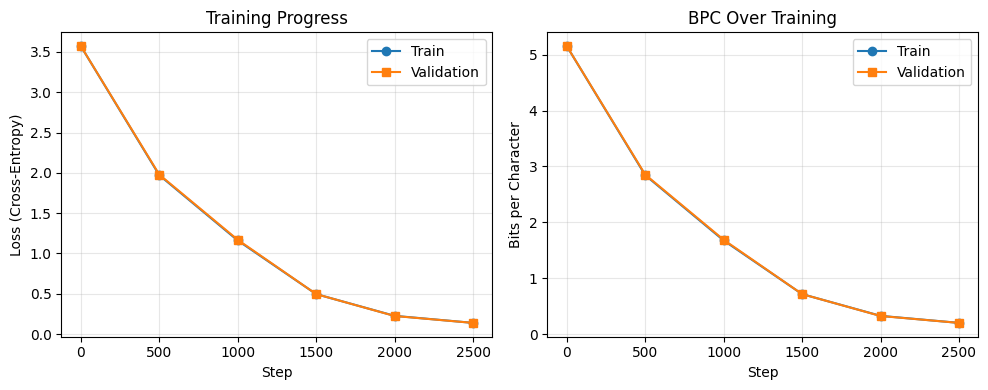


GENERATED SAMPLES

Prompt: 'The ' | Temperature: 0.5
Output: The believe in the beauty of their dreams.
       It fungry, foolish. ishais elis is talitonono tononono

Prompt: 'The ' | Temperature: 0.8
Output: The tusecond best time is now.
        The only impossible journey is is t tis tois thelifonononone tve 

Prompt: 'The ' | Temperature: 1.0
Output: The second best time is now.
         dureangry o.
        Innovation dististnon
 talalnonoon f f f foun

Prompt: 'Success ' | Temperature: 0.5
Output: Success is not final, failure is not fatal: it is the courage to co conttay counearagin tonlinlin tononon t 

Prompt: 'Success ' | Temperature: 0.8
Output: Success is not final, failure is not fatal: it is the courage to co contlive cosearago to ta to ve cono tino

Prompt: 'Success ' | Temperature: 1.0
Output: Success is not final, failure is not fatal: it is the courage to co conttay coun tay to founo ta
 tainonon t

Prompt: 'Your ' | Temperature: 0.5
Output: Your to love what you do.

'\n\n### Expected Training Output\n\nWhen you run this, you should see something like:\n```\nCorpus size: 25000 characters\nVocabulary size: 42 unique characters\nTraining set: 22500 tokens\nValidation set: 2500 tokens\nModel initialized with 198,762 parameters\nUsing device: cuda\n\nStarting training...\n------------------------------------------------------------\nStep     0 | Train loss: 3.7421 (bpc: 5.398) | Val loss: 3.7389 (bpc: 5.394)\nStep   500 | Train loss: 2.1834 (bpc: 3.150) | Val loss: 2.2156 (bpc: 3.196)\n  Sample: The only way to do great work is to love wh...\nStep  1000 | Train loss: 1.6523 (bpc: 2.384) | Val loss: 1.7845 (bpc: 2.574)\n  Sample: The future belongs to those who believe in t...\nStep  1500 | Train loss: 1.3267 (bpc: 1.914) | Val loss: 1.5623 (bpc: 2.254)\n  Sample: The best time to plant a tree was twenty ye...\n...\nStep  5000 | Train loss: 0.8234 (bpc: 1.188) | Val loss: 1.2456 (bpc: 1.797)\n  Sample: The only impossible journey is the one you n...\n--

In [ ]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# 1. Load and prepare data
text = load_text('default')
tokenizer = CharTokenizer(text)
config['vocab_size'] = tokenizer.vocab_size

train_data, val_data = prepare_data(text, tokenizer, config['train_split'])

# 2. Create model
model = TinyTransformerLM(
    vocab_size=config['vocab_size'],
    d_model=config['d_model'],
    num_heads=config['num_heads'],
    num_layers=config['num_layers'],
    d_ff=config['d_ff'],
    max_len=config['max_len'],
    dropout=config['dropout']
).to(device)

# 3. Train
history = train(model, train_data, val_data, tokenizer, config, device)

# 4. Visualize results
plot_training_history(history)

# 5. Generate samples
print("\n" + "="*60)
print("GENERATED SAMPLES")
print("="*60)

prompts = ["The ", "Success ", "Your "]
for prompt in prompts:
    model.eval()
    prompt_ids = torch.tensor([tokenizer.encode(prompt)], device=device)

    # Try different temperatures
    for temp in [0.5, 0.8, 1.0]:
        generated = model.generate(prompt_ids, max_new_tokens=100, temperature=temp)
        text = tokenizer.decode(generated[0].tolist())
        print(f"\nPrompt: '{prompt}' | Temperature: {temp}")
        print(f"Output: {text}")

"""

### Expected Training Output

When you run this, you should see something like:
```
Corpus size: 25000 characters
Vocabulary size: 42 unique characters
Training set: 22500 tokens
Validation set: 2500 tokens
Model initialized with 198,762 parameters
Using device: cuda

Starting training...
------------------------------------------------------------
Step     0 | Train loss: 3.7421 (bpc: 5.398) | Val loss: 3.7389 (bpc: 5.394)
Step   500 | Train loss: 2.1834 (bpc: 3.150) | Val loss: 2.2156 (bpc: 3.196)
  Sample: The only way to do great work is to love wh...
Step  1000 | Train loss: 1.6523 (bpc: 2.384) | Val loss: 1.7845 (bpc: 2.574)
  Sample: The future belongs to those who believe in t...
Step  1500 | Train loss: 1.3267 (bpc: 1.914) | Val loss: 1.5623 (bpc: 2.254)
  Sample: The best time to plant a tree was twenty ye...
...
Step  5000 | Train loss: 0.8234 (bpc: 1.188) | Val loss: 1.2456 (bpc: 1.797)
  Sample: The only impossible journey is the one you n...
------------------------------------------------------------
Training complete!"""